# Load the Routing Environment

In [4]:
%load_ext autoreload
%autoreload 2

import torch
from rl4co.envs import DARPEnv
from rl4co.envs.routing import DARPGenerator
from rl4co.models import AttentionModelPolicy, REINFORCE
from rl4co.utils.trainer import RL4COTrainer
from lightning.pytorch.callbacks import ModelCheckpoint, RichModelSummary

`DARPGenerator` creates a tensordict that includes the starting configuration of a routing scenario, which includes: 
- `depot`: All vehicles share a single depot
- `capacity`: A tensor of homogenous capacities, configured by *vehicle_capacity*

In [17]:
# Generate DARP Problem instance
instance = DARPGenerator(num_loc=10,num_agents=1)._generate(batch_size=[2])
print("Attribute of DARP instance: ", instance.keys())
print("depot (Assuming all vehicles start from the same depots):\n", instance['depot'].shape) # Single depot would suffice for now. 
print("capacity (homogenous fleet of (default 5) vehicles): \n ",  instance['capacity'].shape)
print("locs (consecutive nodes are pickup & dropoff for same request): \n", instance['locs'].shape)
print("time_windows (discretized to 30min interval):\n",  instance['time_windows'].shape)
print("capacity (positive for pickup, negative for dropoff) \n", instance["demand"].shape)

Attribute of DARP instance:  _StringKeys(dict_keys(['locs', 'depot', 'time_windows', 'demand', 'capacity']))
depot (Assuming all vehicles start from the same depots):
 torch.Size([2, 2])
capacity (homogenous fleet of (default 5) vehicles): 
  torch.Size([2, 1])
locs (consecutive nodes are pickup & dropoff for same request): 
 torch.Size([2, 10, 2])
time_windows (discretized to 30min interval):
 torch.Size([2, 10])
capacity (positive for pickup, negative for dropoff) 
 torch.Size([2, 10])


load the DARP Env

- num_loc: 2*requests (pickup & dropoff nodes)
- num_agents: How many vehicles are we using? 
- env.reset(batch_size): çreate a batch of tensor-dict problem instances (why a batch? To parallelize learning? or to Batch-SGD?)

Note that there are more fields in this than the above **instance=DARPGenerator**, because **instance** is just description of a DARP problem (requests of a day), while the tensordict from env records a MDP state (which vehicle we are operating on, which nodes have been visited). 

1. Why is the size of :::tensor::: demand \[ batch, 11 \] (2*n+1)?

In [15]:
env = DARPEnv(penalty_unvisited=150, generator_params={'num_loc': 40, "num_agents":6}) 

# Policy: neural network, in this case with encoder-decoder architecture
# TODO: Understanding how the dict gets encoded to policy
policy = AttentionModelPolicy(env_name=env.name, 
                              embed_dim=128,
                              num_encoder_layers=2,
                              num_heads=8,
                            )

# RL Model: REINFORCE and greedy rollout baseline
model = REINFORCE(env, 
                    policy,
                    baseline="rollout",
                    batch_size=512,
                    train_data_size=50000,
                    val_data_size=500,
                    optimizer_kwargs={"lr": 1e-4},
                    metrics={"train": ["reward", "successful_requests"], 
                            "val": ["reward", "successful_requests"]}
                    ) 



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)

print(td_init)
policy = policy.to(device)
out = policy(td_init.clone(), env=env, phase="test", decode_type="greedy", return_actions=True)

print("Raw Output: \n")
print(out)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([3, 41]), device=cpu, dtype=torch.bool, is_shared=False),
        capacity: Tensor(shape=torch.Size([3, 6]), device=cpu, dtype=torch.int64, is_shared=False),
        current_agent: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        current_load: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        current_node: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        current_time: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        demand: Tensor(shape=torch.Size([3, 41]), device=cpu, dtype=torch.float32, is_shared=False),
        depot: Tensor(shape=torch.Size([3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        i: Tensor(shape=torch.Size([3, 1]), device=cpu, dtyp

In [11]:
# Check for num of valid pairs being transported
x = out['actions'][1]

def check_successful_requests(actions):
    successions = []
    cur = []
    for v in x.tolist():
        if v == 0:
            if cur:
                successions.append(cur) 
                cur = []
        else:
            cur.append(v)
    if cur:
        successions.append(cur)
    
    valid_pairs = set()
    
    for seq in successions:
        s = set(seq)
        # only look at even numbers in this succession
        for v in seq:
            if v % 2 == 0:           # v = 2*i
                i = v // 2
                if (2 * i - 1) in s:  # check the odd partner
                    valid_pairs.add(i)
    return len(valid_pairs)


print(check_successful_requests(x))

18


Problem 1 | Cost: 2356.958
Problem 2 | Cost: 2726.490
Problem 3 | Cost: 2547.020
tensor([[ 3,  1, 19,  5, 20,  6, 31,  4,  2, 13, 14,  9, 10,  7,  8, 27, 21, 22,
          0, 25, 23, 26, 39, 40, 37, 29, 30, 17, 18, 24, 11, 12, 38, 33, 34,  0,
         15, 16, 35, 36,  0,  0,  0,  0],
        [13,  5,  6,  3,  4, 11, 12, 14, 23, 24, 21,  1,  2, 22, 37, 38,  0, 17,
         18,  9, 10, 25, 35, 36, 33,  7,  8, 19, 20, 39, 40,  0, 27, 28, 29, 30,
         31, 15, 16, 32,  0,  0,  0,  0],
        [11, 12, 13, 15, 14,  5,  3,  6,  9, 10, 39, 16,  4, 27, 28, 37, 38,  0,
          7,  8, 19, 20,  1,  2, 17, 18, 33, 34,  0, 23, 24, 29, 30, 25, 26, 35,
         36,  0, 21, 31, 32, 22,  0,  0]])


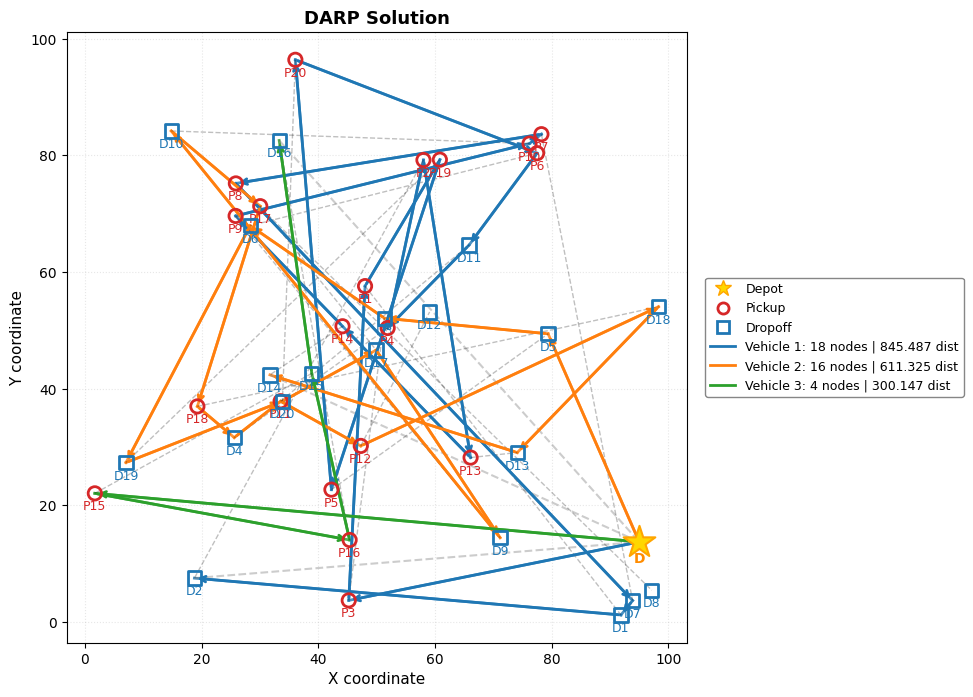

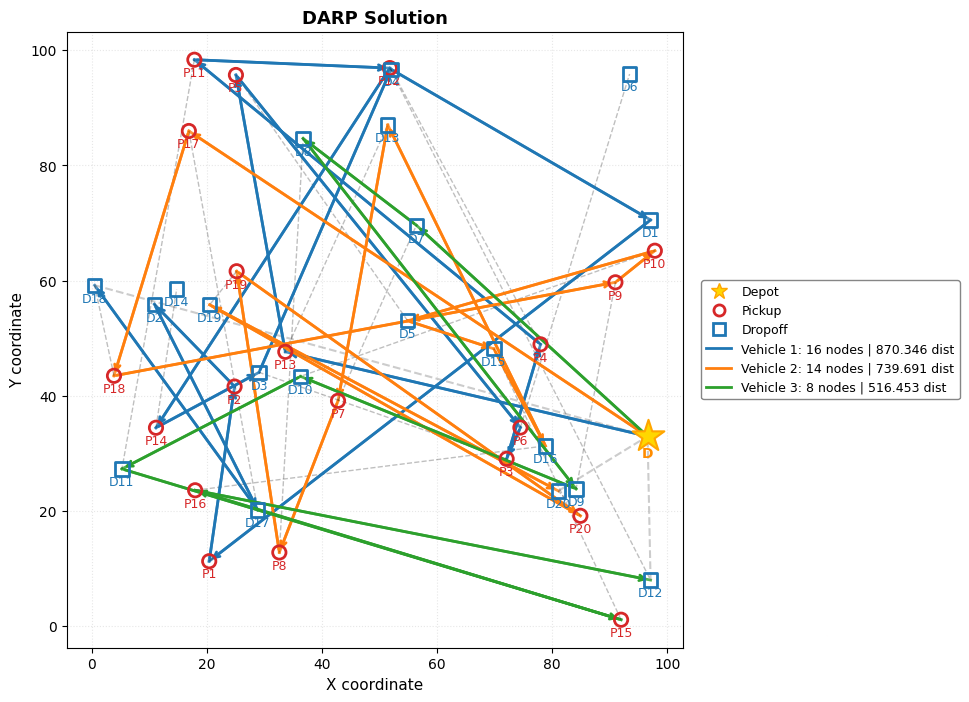

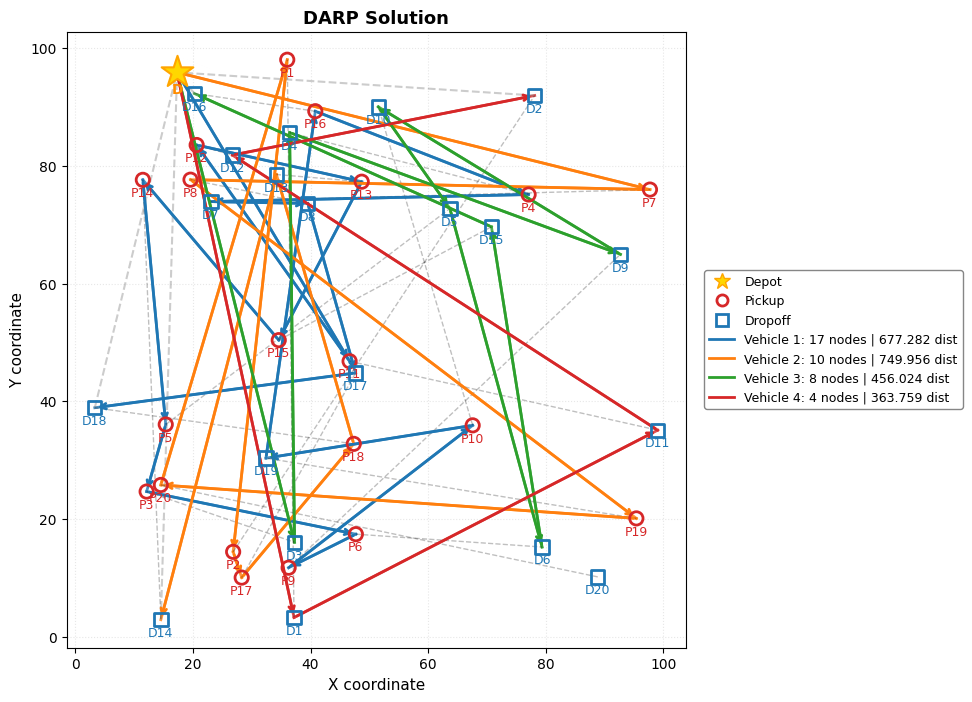

In [13]:
actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

print(actions_untrained)

# Training

In [17]:
# Checkpointing callback: save models when validation reward improves
checkpoint_callback = ModelCheckpoint(  dirpath="checkpoints/20r6v", # save to checkpoints/
                                        filename="darp_epoch_{epoch:03d}",  # save as epoch_XXX.ckpt
                                        save_top_k=1, # save only the best model
                                        save_last=True, # save the last model
                                        monitor="val/reward", # monitor validation reward
                                        mode="max") # maximize validation reward

# Print model summary
rich_model_summary = RichModelSummary(max_depth=3)

# Callbacks list
callbacks = [checkpoint_callback, rich_model_summary]

# Logging

In [23]:
import wandb
wandb.finish()
wandb.login()

/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the

True

In [19]:
from lightning.pytorch.loggers import WandbLogger

logger = WandbLogger(project="rl4co", name="DARP-20r-6v-1") # logger is interface to Wandb

# Trainer

In [24]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=20,
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=callbacks,
    log_every_n_steps=1,
    
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃    ┃ Name                                   ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0  │ env                                    │ DARPEnv               │      0 │ train │
│ 1  │ policy                                 │ AttentionModelPolicy  │  514 K │ train │
│ 2  │ policy.encoder                         │ AttentionModelEncoder │  398 K │ train │
│ 3  │ policy.encoder.init_embedding          │ DARPInitEmbedding     │  1.9 K │ train │
│ 4  │ policy.encoder.net                     │ GraphAttentionNetwork │  396 K │ train │
│ 5  │ policy.decoder                         │ AttentionModelDecoder │  116 K │ train │
│ 6  │ policy.decoder.context_embedding       │ DARPContext           │ 33.4 K │ train │
│ 7  │ policy.decoder.dynamic_embedding       │ DARPDynamicEmbedding  │  1.2 K │ train │
│ 8  │ policy.decoder.pointer                 │ PointerAttention      │ 16.4 K │ train │
│ 9  │ policy.decoder.project_node_embeddings │ Linear                │ 49.2 K │ train │
│ 10 │ policy.decoder.project_fixed_context   │ Linear                │ 16.4 K │ train │
│ 11 │ baseline                               │ WarmupBaseline        │  514 K │ train │
│ 12 │ baseline.baseline                      │ RolloutBaseline       │  514 K │ train │
│ 13 │ baseline.baseline.policy               │ AttentionModelPolicy  │  514 K │ eval  │
│ 14 │ baseline.warmup_baseline               │ ExponentialBaseline   │      0 │ train │
└────┴────────────────────────────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 1.0 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.0 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 58                                                                                          
Modules in eval mode: 54

Sanity Checking: |                                          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:527: Found 54 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is in

Training: |                                                 | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                               | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...

KeyboardInterrupt

